# Assignment 2
**Samuel Sheehy (Student ID 18143565)**

**Techniques of High Performance Computing (PHAS0102)**

**MSc Scientific Computing, University College London**, **2019-2020**

## Setup
This cell imports the libraries and defines the helper functions
that will be used for the entirety of the assignment.

In [181]:
# Enture libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pyopencl as cl

# Specific Functions
from scipy.sparse import find, random, csr_matrix
from scipy.sparse.linalg import LinearOperator, cg


# User-define helper functions
class Timer:
    """
    A simple timer class to measure the execution time
    of a function (seconds) in a ```with``` block.
    Taken from module lecture notes.
    """
    def __enter__(self):
        """
        Measure time at start.
        """
        self.start = time.time()
        return self

    def __exit__(self, *args):
        """
        Measure time at end and take difference
        from start.
        """
        self.end = time.time()
        self.interval = self.end - self.start

## Question 1: OpenCL CSR matrix-vector product

#### Approach:
The matvec is a series of additions and multiplications that must be done multiple times for different data elements. To optimise performance, we parallelise each row/vector-element operation, and within each of these we use SIMD features to maximise execution speed.


In [182]:
# Here we generate a random sparse matrix in the CSR format
# and save it as three distinct objects (index pointers, 
# indicies and data)
def generate_sparse_matrix(rows, columns, density=0.3):
    """
    Generate a random sparse matrix of shape (rows x columns)
    in CRS format and return the index pointer array, column 
    indices and data as three distinct objects as well as a
    dense copy of the matrix.
    """
    sparse_matrix = random(rows, columns, density=density, format='csr')
    return (sparse_matrix.indptr, sparse_matrix.indices,
            sparse_matrix.data), sparse_matrix.A

# Set size of the matrix
N = 100
rows = N
columns = N
# Execute matrix generation and aquire it in 
# both sparse and dense format (for testing)
(A_sparse_matrix), A_copy = generate_sparse_matrix(rows, columns)

In [24]:
def bytesize(N, dtype_str):
    """
    Returns the number of bytes that an array of element
    size N occupies
    """
    if dtype_str == 'float64':
        return N*4
    elif dtype_str == 'uint64':
        return N*4
    elif dtype_str == 'double':
        return N*8


class OpenCL_LOp(LinearOperator):
    """
    Created in reference to the PyLops Linear Operator tutorial.
    """
    def __init__(self, rows, columns, sparse_matrix, data_type=np.float64):
        """
        Set up the subclass, giving it the required properties: shape,
        data type and whether its inverse can be found explicitly, and
        the matrix itself
        """
        # Setup parameters
        self.shape = [rows, columns]
        self.dtype =  np.dtype(data_type)
        self.explicit = False
        # Store the sparse matrix
        self.indptr, self.indices, self.data = sparse_matrix
        # Create the OpenCL tool
        self.openCL_matvec = initialise_OCL_kernel(self.indptr,
            self.indices, self.data, self.shape)

    def _matvec(self, x):
        """
        Apply the initialised operator to the given vector.
        """
        return self.openCL_matvec(x)


def initialise_slow_kernel(indptr, indicies, data, shape):
    """
    Generate a simple operator to perform
    the matrix-vector product of the given sparse
    matrix on a vector x.
    """
    def func(x):
        """"""
        y = np.zeros(shape[0])
        n = len(indptr) - 1
        for i in range(n):
            y[i] = data[indptr[i]:indptr[i+1]].dot(
                x[indices[indptr[i]:indptr[i+1]]]
            )
        return y
        """"""
    return func


def initialise_OCL_kernel(indptr, indicies, data, shape):
    """
    Generate OpenCL-implemented operator to perform
    the matrix-vector product of the given sparse
    matrix on a vector x.
    """
    # Unpack shape parameter
    mat_rows, columns = shape
    # OpenCL C-Language Kernel
    # This implements the row-wise dot product
    kernel = """
        __kernel void matvec(
            __global uint *indptr,
            __global uint *indicies,
            __global double *data,
            __global double *myvector,
            __global double *result
        )
        {        
        // Get Global Identifiers i.e. the row index
        int row_index = get_global_id(0);

        // Do the dot product
        int start = indptr[row_index];
        int end = indptr[row_index + 1];
        int k;
        double sum = 0;
        double8 data_8;
        double8 vector_8;
        double8 product_8;
        int extra = (end-start) % 8;
        
        for(k=start; k < end-extra; k=k+8){
            
            data_8 = (double8)(data[k + 0],
                               data[k + 1],
                               data[k + 2],
                               data[k + 3],
                               data[k + 4],
                               data[k + 5],
                               data[k + 6],
                               data[k + 7]);
                               
            vector_8 = (double8)(myvector[indicies[k + 0]],
                                 myvector[indicies[k + 1]],
                                 myvector[indicies[k + 2]],
                                 myvector[indicies[k + 3]],
                                 myvector[indicies[k + 4]],
                                 myvector[indicies[k + 5]],
                                 myvector[indicies[k + 6]],
                                 myvector[indicies[k + 7]]);
        
            product_8 = data_8 * vector_8;
            
            sum += product_8.s1 + product_8.s2
                   + product_8.s3 + product_8.s4
                   + product_8.s5 + product_8.s6
                   + product_8.s7 + product_8.s0;
        }
        
        // Move the counter up to the last accessed
        // element and calculate the products individually for the 
        // terms that are too few for a double8
        for(int k = end-extra; k < end; k=k+1){
            sum += data[k]*myvector[indicies[k]];
        }       
        
        // Output answer
        result[row_index] = sum;
        
        }
    """
    # Initialise the OpenCL environment
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    
    # Create the buffers to hold the sparse matrix data
    indptr_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=indptr)
    indicies_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=indicies)
    data_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=data)
    
    # Create the buffer to hold the vector data
    vector_buffer = cl.Buffer(ctx, mf.READ_ONLY, bytesize(columns, 'double'))
    mapped_vector_buffer, linking_event = cl.enqueue_map_buffer(
        queue, vector_buffer, cl.map_flags.WRITE, 0, columns, np.dtype('double'))
    linking_event.wait()
    
    # Create buffer to hold the result
    result_buffer = cl.Buffer(ctx, mf.READ_WRITE, bytesize(mat_rows, 'double'))
#     mapped_result, _ = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ,
#                                       0, mat_rows, np.double) 

    
    # Build the Kernel
    prg = cl.Program(ctx, kernel)
    prg.build()
    matvec_kernel = prg.matvec
    
    # Define what to be executed when matvec is called
    def exec_kernel(x):
        # Rewrite vector buffer
        mapped_vector_buffer[:] = x

        # Run the kernel
        matvec_kernel(
            # Workspace parameters
            queue, (mat_rows, ), (1, ),
            # Buffers
            indptr_buffer, indicies_buffer, data_buffer,
            vector_buffer, result_buffer
        )
        
        mapped_result, _ = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ,
                                      0, mat_rows, np.double) 
        return mapped_result
    # Pass the kernel executor to the class
    return exec_kernel

In [25]:
mylop = OpenCL_LOp(rows, columns, A_sparse_matrix)
x = np.ones(columns)

with Timer() as t:
    control = A_copy.dot(x)
print(t.interval)

with Timer() as t:
    myres = mylop.matvec(x)
print(t.interval)

# print(np.linalg.norm(control - myres))
# print(control)
# print(myres)
np.allclose(control, myres)

3.4332275390625e-05
0.0004830360412597656


True

## Question 2: Solving a Poisson Problem with OpenCL

To consider:
* Parallelisation is over all interior points
* BCs are all 0

Steps:
1. Implement a LOP
2. Integrate LOP into CG solver
3. Analyse with M: (a) convergence of residual, (b) number of iterations
4. Plot the solution

### Construct the Matrix

In [152]:
def shift(N, k):
    """
    Return the indicies of the diagonal+k of a square
    matrix.
    """
    i, j = np.diag_indices(N)
    shifted_j = [x+k for x in j]
    if k > 0:
        shifted_i = i[0:-k]
        shifted_j = shifted_j[0:-k]
    elif k < 0:
        shifted_i = i[abs(k):]
        shifted_j = shifted_j[abs(k):]
    else:
        return i, j
    return shifted_i, np.array(shifted_j)


def drop_edges(diag_indx, val, N):
    """
    Return the indicies of the given tuple with those
    corresponding to edge fields dropped, indicated 
    by val (either 2 or N-1).
    """
    # Row gives pairing
    rows, columns = diag_indx
    i = rows//(N-2)+2
    j = rows%(N-2)+2
    
    rows = [row for row, jx in zip(rows, j) if jx != val]
    columns = [col for col, jx in zip(columns, j) if jx != val]
    return rows, columns


def generate_operator_matrix(N):
    """
    Generates a sparse matrix to operate on the
    problem for a given edge size N
    """
    # Size of the Operator
    Nop = N**2 - 2*N - 2*(N-2)

    # Create the Operator Matrix
    # Diagonal of 4
    A = np.eye(Nop)*4

    # Diagonal+1 of -1 except when j=N-1
    shift_plus_1 = shift(Nop, 1)
    shift_plus_1m = drop_edges(shift_plus_1, N-1, N)

    A[shift_plus_1m] = -1

    # Diagnoal-1 of -1 except when j=2
    shift_minus_1 = shift(Nop, -1)
    shift_minus_1m = drop_edges(shift_minus_1, 2, N)
    A[shift_minus_1m] = -1

    # Diagonal+(N-2) of -1
    A[shift(Nop, N-2)] = -1

    # Diagonal-(N-2) of -1
    A[shift(Nop, -(N-2))] = -1

    return Nop, csr_matrix(A)


def generate_OCL_LOP(N):
    """
    """
    Nop, A_sp = generate_operator_matrix(N)
    sparse_matrix = (A_sp.indptr, A_sp.indices, A_sp.data)
    CGLop = OpenCL_LOp(Nop, Nop, sparse_matrix)
    return Nop, CGLop

In [153]:
Nop, A_sp = generate_operator_matrix(75)
sparse_matrix = (A_sp.indptr, A_sp.indices, A_sp.data)
CGLop = OpenCL_LOp(Nop, Nop, sparse_matrix)

with Timer() as t:
    u_Asp, info_Asp = cg(A_sp, np.ones(Nop))
print(t.interval)

with Timer() as t:
    u_lop, info_lop = cg(CGLop, np.ones(Nop))
print(t.interval)

# print(np.linalg.norm(u_Asp - u_lop))
# print(u_lop)
# print(u_Asp)
np.allclose(u_lop, u_Asp)

0.014901161193847656
0.037316083908081055


True

In [154]:
def measure_convergence(LOP, Nop):
    """
    For each iterate, measure and record the residual.
    """
    b = np.ones(Nop)
    record = []
    def residual(u):
        """
        Calculate the residual.
        """
        residual = np.linalg.norm(b-LOP.matvec(u), 2)/np.linalg.norm(b)
        record.append(residual)
    # Execute solve and return results
    usol, info = cg(LOP, b, callback=residual)    
    return usol, record


def multi_N_convergence(N_list):
    """
    Solves the problem and measures convergence
    for each problem of size given in the list.
    """
    multi_residuals = []
    muti_iterates = []
    for N in N_list:
        Nop, A_sp = generate_operator_matrix(N)
        sparse_matrix = (A_sp.indptr, A_sp.indices, A_sp.data)
        CGLop = OpenCL_LOp(Nop, Nop, sparse_matrix)
        _, residuals = measure_convergence(CGLop, Nop)
        iterates = [i for i, _ in enumerate(residuals)]
        multi_residuals.append(residuals)
        muti_iterates.append(iterates)
    return muti_iterates, multi_residuals

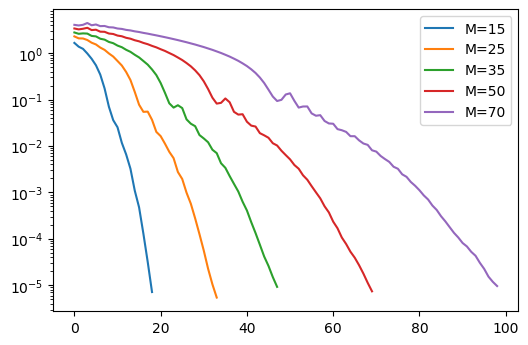

In [180]:
N_list = [15, 25, 35, 50, 70]
iterations, residuals_list = multi_N_convergence(N_list)
for N, iterates, residuals in zip(N_list, iterations, residuals_list):
    plt.semilogy(iterates, residuals, label='M=%i'%N)
    plt.legend()
fig = plt.gcf()
fig.set_dpi(100)
plt.show()

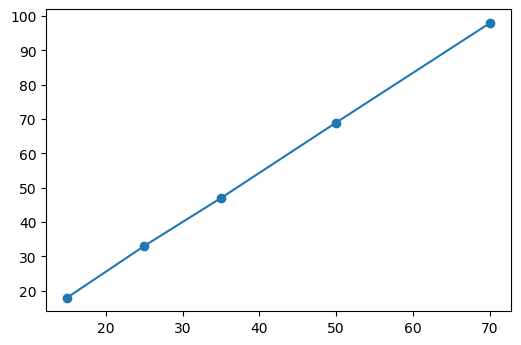

In [176]:
iter_count = [iterates[-1] for iterates in iterations]
plt.plot(N_list, iter_count, '-o')
fig = plt.gcf()
fig.set_dpi(100)
plt.show()

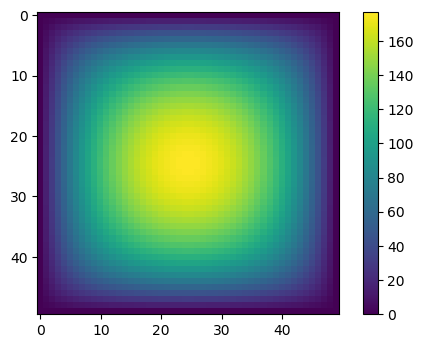

In [179]:
def format_shape(sol, N):
    """
    Formats the solution vector back into
    the original shape and adding in the 
    boundary conditions.
    """
    # The inner square does not have the 1st or
    # last value
    inner_N = N-2
    shaped = sol.reshape((inner_N, inner_N))
    # Return the reshaped array with 0's around it
    # corresponding to the BC's
    return np.pad(shaped, 1, mode='constant')

N=50
Nop, LOP = generate_OCL_LOP(N)
sol, info_lop = cg(LOP, np.ones(Nop))
plt.imshow(format_shape(sol, N))
plt.colorbar()
fig = plt.gcf()
fig.set_dpi(100)